In [ ]:
# ALWAYS USE FOR COORDINATES THE TRACKING DATASET

In [6]:
import requests
import pandas as pd
import json
import numpy as np
from scipy.spatial.distance import cdist
import os
from datetime import timedelta
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, LineString,Point, box
from kloppy import skillcorner
from kloppy.domain import Team
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from urllib.request import urlopen
from matplotlib.animation import FuncAnimation

from PIL import Image

from mplsoccer import PyPizza, add_image, FontManager


# Setup pitch and plot
from mplsoccer import Pitch
#from mplsoccer.pitch import Pitch ,VerticalPitch

# username = "XXX"
# password = "XXX"


# from skillcorner.client import SkillcornerClient
# client=SkillcornerClient(username=username,password=password)

def time_to_seconds(time_str):
    if time_str is None:
        return 90 * 60  # 120 minutes = 7200 seconds
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s

font_normal = FontManager('https://raw.githubusercontent.com/googlefonts/roboto/main/'
                          'src/hinted/Roboto-Regular.ttf')
font_italic = FontManager('https://raw.githubusercontent.com/googlefonts/roboto/main/'
                          'src/hinted/Roboto-Italic.ttf')
font_bold = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/'
                        'RobotoSlab[wght].ttf')

In [7]:
def load_matches(matches_json_path):

    with open(matches_json_path, "r") as f:
        matches_json = json.load(f)

    match_ids = [match["id"] for match in matches_json]

    all_tracking = []

    for match_id in match_ids:
        tracking_data_github_url = f'https://media.githubusercontent.com/media/SkillCorner/opendata/741bdb798b0c1835057e3fa77244c1571a00e4aa/data/matches/{match_id}/{match_id}_tracking_extrapolated.jsonl'
        
        dataset = skillcorner.load(
            meta_data=f'https://raw.githubusercontent.com/SkillCorner/opendata/741bdb798b0c1835057e3fa77244c1571a00e4aa/data/matches/{match_id}/{match_id}_match.json',
            raw_data=tracking_data_github_url,
            # Optional arguments,
            coordinates="skillcorner",
            include_empty_frames=False)

        all_tracking.append(dataset)

    all_de_dfs = []

    for match_id in match_ids:
        url = f"https://raw.githubusercontent.com/SkillCorner/opendata/master/data/matches/{match_id}/{match_id}_dynamic_events.csv"
        try:
            de_match = pd.read_csv(url)
            all_de_dfs.append(de_match)
        except Exception as e:
            print(f"Failed to load dynamic events for match {match_id}: {e}")

    de_all_matches = pd.concat(all_de_dfs, ignore_index=True)

    all_metadata = []

    for match_id in match_ids:
        metadata_match = f'https://raw.githubusercontent.com/SkillCorner/opendata/741bdb798b0c1835057e3fa77244c1571a00e4aa/data/matches/{match_id}/{match_id}_match.json'
        response = requests.get(metadata_match)
        raw_match_data = response.json()
        all_metadata.append(raw_match_data)

    
    return all_tracking, de_all_matches, all_metadata
        

In [8]:
# Load matches

matches_json_path = os.path.join(os.path.dirname(os.getcwd()), "data/matches.json")
all_tracking, de_all_matches, all_metadata = load_matches(matches_json_path)

C:\Users\gausachsfernandezg\AppData\Local\Temp\ipykernel_15004\39286862.py:27: DtypeWarning: Columns (75,77,184,264) have mixed types. Specify dtype option on import or set low_memory=False.
  de_match = pd.read_csv(url)
C:\Users\gausachsfernandezg\AppData\Local\Temp\ipykernel_15004\39286862.py:27: DtypeWarning: Columns (276) have mixed types. Specify dtype option on import or set low_memory=False.
  de_match = pd.read_csv(url)


How can a midfielder create space?
- He moves to another location and his origin location is free.
- Moving to another location creates a pass line.
- Dragging defenders
- pushing defensive line with in behind runs


In [9]:
def midfielders_obe(de_all_matches):
    # Get off-ball events
    off_ball_events = de_all_matches[de_all_matches["event_type_id"] == 1]

    # Get only off ball events from midfielders
    positions_mid = [9,10,11,12,13,14,15]
    mid_obe = off_ball_events[off_ball_events["player_position_id"].isin(positions_mid)].copy()

    # For every obe, column id equals event_id_match_id
    mid_obe["id"] = mid_obe["event_id"].astype(str) + "_" + mid_obe["match_id"].astype(str)
    mid_obe = mid_obe.reset_index(drop=True)

    # Data matching
    mid_obe = mid_obe[
            (mid_obe["is_player_possession_start_matched"] == True) &
            (mid_obe["is_player_possession_end_matched"] == True)
        ]
    return mid_obe

In [10]:
def avg_distance(mid_obe, all_tracking):

    for row in mid_obe.itertuples():
        # Find the match in all_tracking
        match = next((m for m in all_tracking if int(m.metadata.game_id) == int(row.match_id)), None)
        if not match:
                raise ValueError(f"Match {row.match_id} not found in all_tracking")
        
        # Find the start frame in the match frames
        start_frame = next((f for f in match.frames if int(f.frame_id) == int(row.frame_start)), None)
        if not start_frame:
            print(f"Start frame {row.frame_start} not found in match {row.match_id}")
            continue  # Skip if start frame not found
        
        end_frame = next((f for f in match.frames if int(f.frame_id) == int(row.frame_end)), None)
        if not end_frame:
            print(f"End frame {row.frame_end} not found in match {row.match_id}")
            continue  # Skip if end frame not found
        
        # Get player coordinates
        player_coord = None
        player_team = None
        for player, coord in start_frame.players_coordinates.items():
            if player.player_id == str(row.player_id):
                player_coord = np.array([coord.x, coord.y])
                player_team = player.team.team_id
                break

        if player_coord is None:
            continue

        # --- Start frame distances ---
        opponents_start = np.array([[c.x, c.y] for p, c in start_frame.players_coordinates.items()
                                    if p.team.team_id != player_team])
        if len(opponents_start) > 0:
            distances_start = cdist([player_coord], opponents_start).flatten()
            close_start = distances_start[distances_start <= 5]
            avg_distance_start = close_start.mean() if len(close_start) > 0 else np.nan
        else:
            avg_distance_start = np.nan

        # --- End frame distances ---
        opponents_end = np.array([[c.x, c.y] for p, c in end_frame.players_coordinates.items()
                                if p.team.team_id != player_team])
        if len(opponents_end) > 0:
            distances_end = cdist([player_coord], opponents_end).flatten()
            close_end = distances_end[distances_end <= 5]
            avg_distance_end = close_end.mean() if len(close_end) > 0 else np.nan
        else:
            avg_distance_end = np.nan

        # Store results in mid_obe DataFrame
        mid_obe.at[row.Index, 'def_density_change'] = avg_distance_end - avg_distance_start
        
    return mid_obe

In [14]:
def get_voronoi_bounded(points, index, pitch_bounds):
    # Add padding points to bound Voronoi
    padding = np.array([
            [-1000, -1000],
            [1000, 1000],
            [1000, -1000],
            [-1000, 1000]
    ])
    points = np.vstack([points, padding])

    # Compute Voronoi
    vor = Voronoi(points)

    # Get region of target player
    region_index = vor.point_region[index]
    region = vor.regions[region_index]

    # Collect finite vertices
    finite_vertices = [vor.vertices[i] for i in region if i != -1]

    poly = Polygon(finite_vertices)

    # Clip with pitch bounds
    poly_clipped = poly.intersection(pitch_bounds)

    if poly_clipped.is_empty:
        raise ValueError("Clipped polygon is empty")

    return poly_clipped

In [15]:
def space_creation(mid_obe, all_tracking):

    # Filter by duration < 5 seconds
    mid_obe = mid_obe[(mid_obe["duration"] <= 5.0)].copy()

    mid_obe = mid_obe.reset_index(drop=True)

    pitch_bounds = box(-52.5, -34, 52.5, 34)  # SkillCorner pitch centered at (0,0)


    # Add a column for Voronoi area changes
    mid_obe["voronoi_area_start"] = np.nan
    mid_obe["voronoi_area_end"] = np.nan
    mid_obe["space_created"] = np.nan
    mid_obe["voronoi_poly_start"] = None
    mid_obe["voronoi_poly_end"] = None

    i = 0
    for row in mid_obe.itertuples():
        # Match
        match = next((m for m in all_tracking 
                      if int(m.metadata.game_id) == int(row.match_id)), None)
        if not match:
            raise ValueError(f"Match {row.match_id} not found in all_tracking")
        
        start_frame = next((f for f in match.frames 
                            if int(f.frame_id) == int(row.frame_start)), None)

        end_frame = next((f for f in match.frames 
                          if int(f.frame_id) == int(row.frame_end)), None)
        
        if not start_frame or not end_frame:
            i+=1
            print(f"Missing frame(s) for row {row.Index}")
            continue

        # Get player index + all positions
        players_start = []
        target_idx_start = None

        for idx, (player, coord) in enumerate(start_frame.players_coordinates.items()):
            if player.player_id == str(row.player_id):
                players_start.append([coord.x, coord.y])
                team_id = player.team.team_id
        
        for idx, (player, coord) in enumerate(start_frame.players_coordinates.items()):
            if player.team.team_id != team_id:
                players_start.append([coord.x, coord.y])

        players_start = np.array(players_start)

        # 1️⃣ Voronoi at start frame
        poly_start = get_voronoi_bounded(players_start, 0, pitch_bounds)
        area_start = poly_start.area if poly_start else np.nan

        # 2️⃣ Voronoi at end frame but **at the original start location**
        players_end = []
        for idx, (player, coord) in enumerate(start_frame.players_coordinates.items()):
            if player.player_id == str(row.player_id):
                players_end.append(players_start[0])
        
        for idx, (player, coord) in enumerate(end_frame.players_coordinates.items()):
            if team_id != player.team.team_id:
                players_end.append([coord.x, coord.y])

        players_end = np.array(players_end)

        poly_end = get_voronoi_bounded(players_end, 0, pitch_bounds)
        area_end = poly_end.area if poly_end else np.nan

        # Store in DataFrame
        mid_obe.at[row.Index, 'voronoi_area_start'] = area_start
        mid_obe.at[row.Index, 'voronoi_area_end'] = area_end
        mid_obe.at[row.Index, 'space_created'] = area_end - area_start
        mid_obe.at[row.Index, 'voronoi_poly_start'] = poly_start
        mid_obe.at[row.Index, 'voronoi_poly_end'] = poly_end
    
    print(f"Skipped {i} rows due to missing frames")

    return mid_obe


In [16]:
mid_obe = midfielders_obe(de_all_matches)
#mid_obe = avg_distance(mid_obe, all_tracking)
mid_obe = space_creation(mid_obe, all_tracking)

Missing frame(s) for row 0
Missing frame(s) for row 1
Missing frame(s) for row 148
Missing frame(s) for row 215
Missing frame(s) for row 234
Missing frame(s) for row 323
Missing frame(s) for row 360
Missing frame(s) for row 361
Missing frame(s) for row 431
Missing frame(s) for row 498
Missing frame(s) for row 505
Missing frame(s) for row 527
Missing frame(s) for row 623
Missing frame(s) for row 639
Missing frame(s) for row 665
Missing frame(s) for row 692
Missing frame(s) for row 701
Missing frame(s) for row 722
Missing frame(s) for row 750
Missing frame(s) for row 775
Missing frame(s) for row 836
Missing frame(s) for row 869
Missing frame(s) for row 870
Missing frame(s) for row 957
Missing frame(s) for row 973
Missing frame(s) for row 975
Missing frame(s) for row 1049
Missing frame(s) for row 1052
Missing frame(s) for row 1144
Missing frame(s) for row 1170
Skipped 30 rows due to missing frames


In [9]:
pitch = Pitch(pitch_type="skillcorner",
              pitch_length=105,
              pitch_width=68,
              pitch_color="#001400",
              line_color="white",
              linewidth=1.5)

In [10]:
def plot_voronoi(pitch, mid_obe, all_tracking, frame = "start", idx=121):

    fig, ax = pitch.grid(figheight=8, endnote_height=0, title_height=0)

    # Select the run
    example_poly_start = mid_obe.at[idx, 'voronoi_poly_start']
    example_poly_end = mid_obe.at[idx, 'voronoi_poly_end']

    if frame == "start":
        if example_poly_start:
            x, y = example_poly_start.exterior.xy
            ax.fill(x, y, color='blue', alpha=0.3, label='Start frame')
    else:
        if example_poly_end:
            x, y = example_poly_end.exterior.xy
            ax.fill(x, y, color='red', alpha=0.3, label='End frame')

    # --- Plot all player coordinates ---
    row = mid_obe.iloc[idx]
    player_id = row.player_id
    print(f"Plotting for player ID: {player_id}")
    match = next((m for m in all_tracking if int(m.metadata.game_id) == int(row.match_id)), None)
    start_frame = next((f for f in match.frames if int(f.frame_id) == int(row.frame_start)), None)
    print(f"Start frame ID: {start_frame.frame_id}")
    print(f"Time: {start_frame.timestamp}")
    end_frame = next((f for f in match.frames if int(f.frame_id) == int(row.frame_end)), None)
    print(f"End frame ID: {end_frame.frame_id}")
    print(f"Time: {end_frame.timestamp}")

    for player, coord in start_frame.players_coordinates.items():
        if player.player_id == str(player_id):
            team_id = player.team.team_id
            if frame == "start":
                ax.scatter(coord.x, coord.y, color='yellow', s=50, zorder=5, label='Runner')  # Runner location
            else:
                ax.scatter(coord.x, coord.y, color='blue', s=50, zorder=5, label='Runner')  # Runner location
            break
    if frame == "start":
        for player, coord in start_frame.players_coordinates.items():
            #if player.team.team_id == team_id and player.player_id != str(player_id):
                #ax.scatter(coord.x, coord.y, color='green', s=50, zorder=5)  # Teammates
            if player.team.team_id != team_id:
                ax.scatter(coord.x, coord.y, color='red', s=50, zorder=5)    # Opponents
    else:
        for player, coord in end_frame.players_coordinates.items():
            #if player.team.team_id == team_id and player.player_id != str(player_id):
                #ax.scatter(coord.x, coord.y, color='green', s=50, zorder=5)  # Teammates
            if player.team.team_id != team_id:
                ax.scatter(coord.x, coord.y, color='red', s=50, zorder=5)    # Opponents
            if player.player_id == str(player_id):
                ax.scatter(coord.x, coord.y, color='yellow', s=50, zorder=5)  # Runner location
    
    # --- Plot the ball ---
    if frame == "start":
        ball_coord = start_frame.ball_coordinates
    else:
        ball_coord = end_frame.ball_coordinates
    ax.scatter(ball_coord.x, ball_coord.y, color='white', s=30, zorder=5, label='Ball')
        
    # --- 5️⃣ Add legend ---
    ax.legend(loc='upper right')

    plt.show()

Plotting for player ID: 51045
Start frame ID: 13011
Time: 0:14:57.100000
End frame ID: 13026
Time: 0:14:58.600000


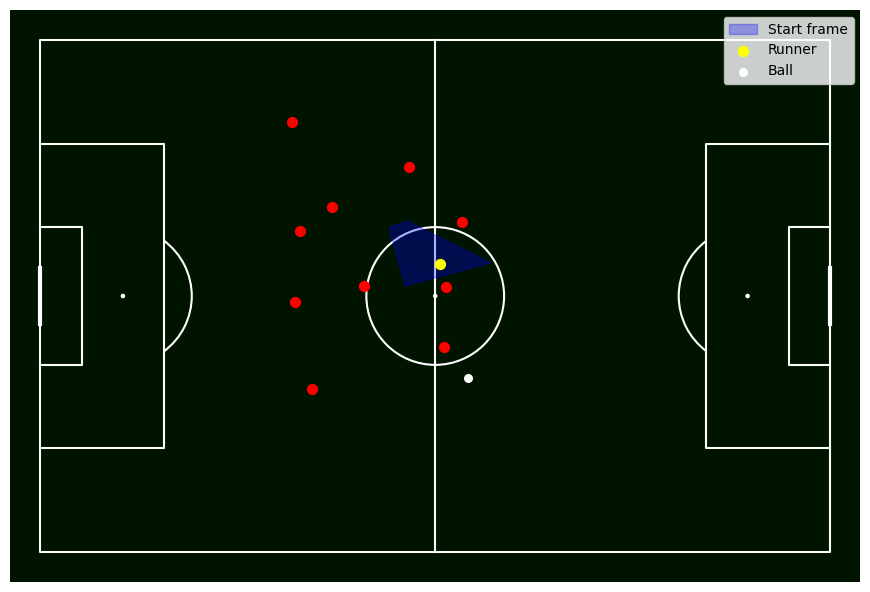

Plotting for player ID: 51045
Start frame ID: 13011
Time: 0:14:57.100000
End frame ID: 13026
Time: 0:14:58.600000


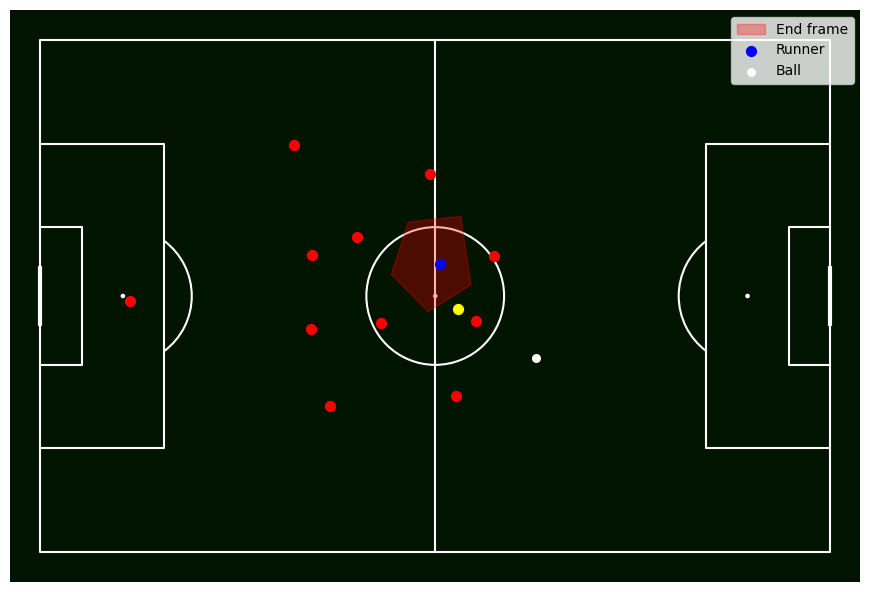

In [11]:
idx = mid_obe.index[mid_obe["id"] == '1_104_2013725'][0]
plot_voronoi(pitch, mid_obe, all_tracking, frame="start", idx=idx)
plot_voronoi(pitch, mid_obe, all_tracking, frame="end", idx=idx)

In [12]:
def filter_space_created_iqr(mid_obe):
    df = mid_obe.copy()

    df = df[
    (df['voronoi_area_start'] <= 500) &
    (df['voronoi_area_end'] <= 500) &
    (df['space_created'] <= 150) &
    (df['space_created'] >= -150)
    ].copy()

    filtered_df_list = []

    for subtype in df['event_subtype'].unique():
        subtype_df = df[df['event_subtype'] == subtype]
        # Calculate IQR boundaries
        Q1 = subtype_df['space_created'].quantile(0.25)
        Q3 = subtype_df['space_created'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Filter with IQR bounds
        filtered_subtype_df = subtype_df[(subtype_df['space_created'] >= lower_bound) &
                                        (subtype_df['space_created'] <= upper_bound)].copy()
        filtered_df_list.append(filtered_subtype_df)

    # Concatenate all filtered subtypes back together
    filtered_df = pd.concat(filtered_df_list, ignore_index=True)

    # Now filtered_df contains your contextually-cleaned data!
    return filtered_df

In [13]:
mid_obe = filter_space_created_iqr(mid_obe)
print(len(mid_obe))

710


In [60]:
# for every event subtype

event_subtypes = mid_obe['event_subtype'].unique()
for subtype in event_subtypes:
    subtype_df = mid_obe[mid_obe['event_subtype'] == subtype]
    print(f"Event Subtype: {subtype}")
    print(f"Number of events: {len(subtype_df)}")
    print(f"Average space created: {subtype_df['space_created'].mean()}")
    print(f"Median space created: {subtype_df['space_created'].median()}")
    print(f"Percentile 25 space created: {subtype_df['space_created'].quantile(0.25)}")
    print(f"Percentile 75 space created: {subtype_df['space_created'].quantile(0.75)}")
    # for vooronoi area start and end
    print(f"Average voronoi area start: {subtype_df['voronoi_area_start'].mean()}")
    print(f"Average voronoi area end: {subtype_df['voronoi_area_end'].mean()}")
    print(f"Median voronoi area start: {subtype_df['voronoi_area_start'].median()}")
    print(f"Median voronoi area end: {subtype_df['voronoi_area_end'].median()}")
    print(f"Percentile 25 voronoi area start: {subtype_df['voronoi_area_start'].quantile(0.25)}")
    print(f"Percentile 75 voronoi area start: {subtype_df['voronoi_area_start'].quantile(0.75)}")
    print(f"Percentile 25 voronoi area end: {subtype_df['voronoi_area_end'].quantile(0.25)}")
    print(f"Percentile 75 voronoi area end: {subtype_df['voronoi_area_end'].quantile(0.75)}")
    
    # give me the id of an event with a space_created > 150 or < -150
    high_space_events = subtype_df[(subtype_df['space_created'] > 150) | (subtype_df['space_created'] < -150)]
    if not high_space_events.empty:
        example_idx = high_space_events.index[0]
        print(f"Example event ID with high space created: {mid_obe.at[example_idx, 'id']}, Space Created: {mid_obe.at[example_idx, 'space_created']}")
    normal_event = subtype_df[(subtype_df['space_created'] <= 150) & (subtype_df['space_created'] >= -150) &
                              (subtype_df['voronoi_area_start'] < 500) & (subtype_df['voronoi_area_end'] < 500)]
    if not normal_event.empty:
        example_idx = normal_event.index[0]
        print(f"Example event ID with normal space created: {mid_obe.at[example_idx, 'id']}, Space Created: {mid_obe.at[example_idx, 'space_created']}")
    print("-----")

Event Subtype: run_ahead_of_the_ball
Number of events: 238
Average space created: 191.5283843765704
Median space created: 33.55259987385193
Percentile 25 space created: -7.4754081164522574
Percentile 75 space created: 146.042466194647
Average voronoi area start: 155.2461173933758
Average voronoi area end: 346.7745017699462
Median voronoi area start: 92.13170059261512
Median voronoi area end: 150.90533874442374
Percentile 25 voronoi area start: 61.988741969080124
Percentile 75 voronoi area start: 158.86733196521118
Percentile 25 voronoi area end: 79.96898127286136
Percentile 75 voronoi area end: 333.74311580085043
Example event ID with high space created: 1_6_2017461, Space Created: 537.6664442912244
Example event ID with normal space created: 1_36_2017461, Space Created: 16.38559905322259
-----
Event Subtype: coming_short
Number of events: 416
Average space created: 121.99777990962906
Median space created: 14.745208499154792
Percentile 25 space created: -19.7381786381617
Percentile 75 

Number of events for subtype run_ahead_of_the_ball: 162
Percentage of total events: 22.82%


C:\Users\g4a4b\AppData\Local\Temp\ipykernel_21820\3839755185.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subtype_df[c].dropna() for c in cols], labels=cols)


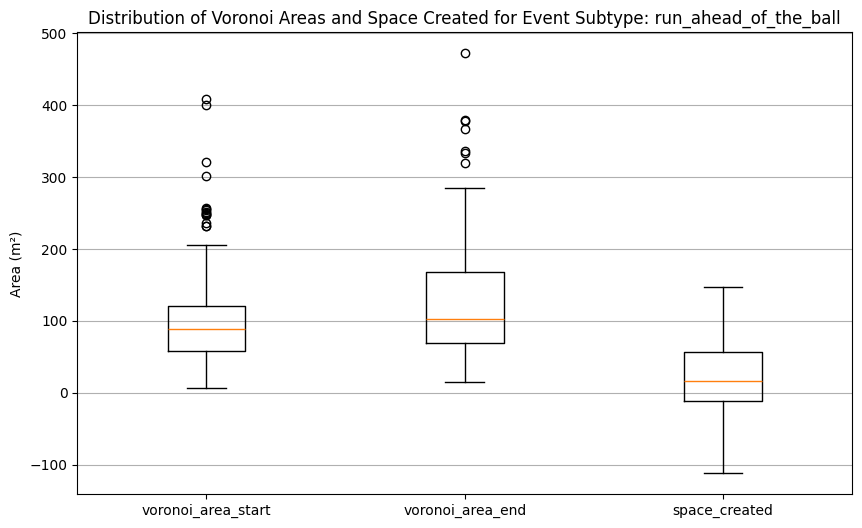

Number of events for subtype coming_short: 271
Percentage of total events: 38.17%


C:\Users\g4a4b\AppData\Local\Temp\ipykernel_21820\3839755185.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subtype_df[c].dropna() for c in cols], labels=cols)


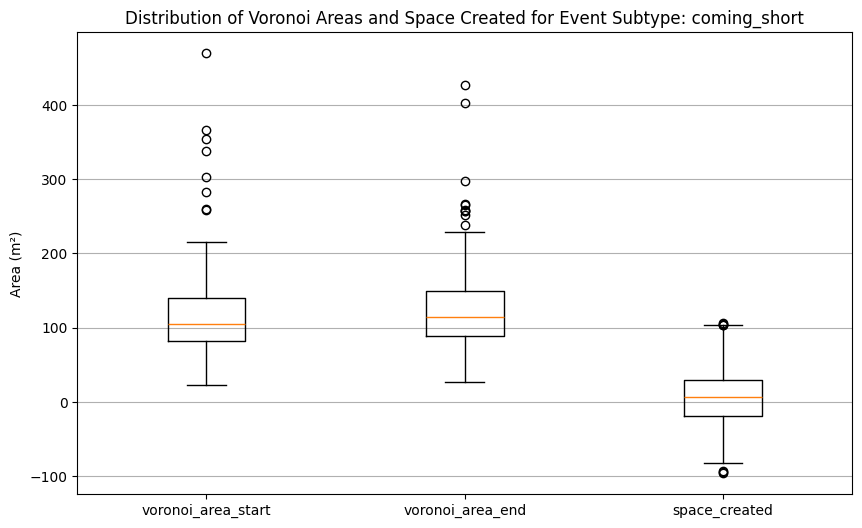

Number of events for subtype support: 124
Percentage of total events: 17.46%


C:\Users\g4a4b\AppData\Local\Temp\ipykernel_21820\3839755185.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subtype_df[c].dropna() for c in cols], labels=cols)


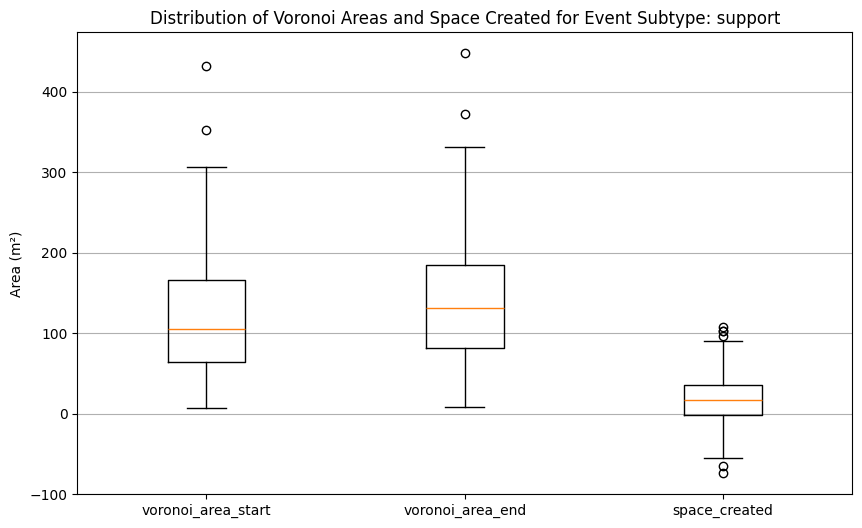

Number of events for subtype pulling_half_space: 27
Percentage of total events: 3.80%


C:\Users\g4a4b\AppData\Local\Temp\ipykernel_21820\3839755185.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subtype_df[c].dropna() for c in cols], labels=cols)


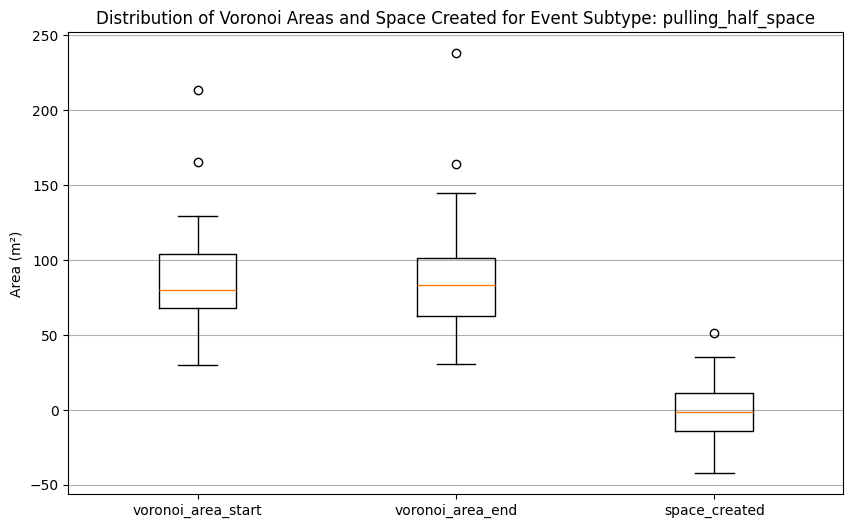

Number of events for subtype cross_receiver: 19
Percentage of total events: 2.68%


C:\Users\g4a4b\AppData\Local\Temp\ipykernel_21820\3839755185.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subtype_df[c].dropna() for c in cols], labels=cols)


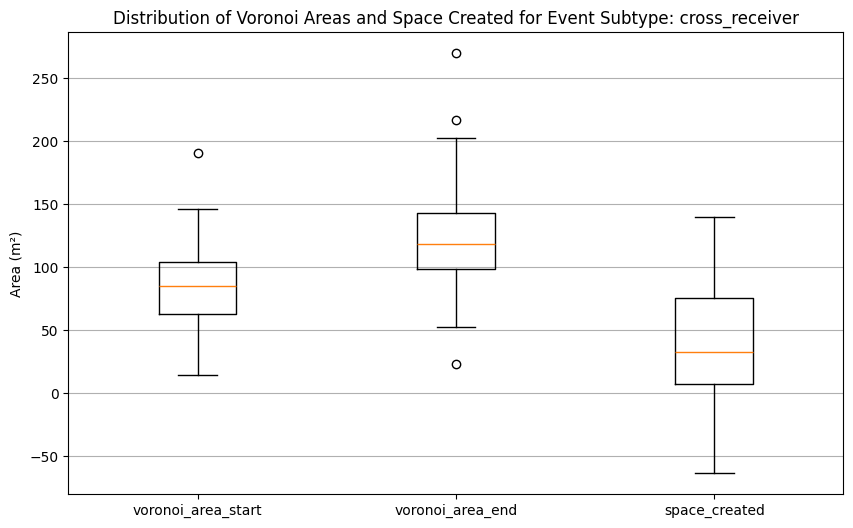

Number of events for subtype underlap: 11
Percentage of total events: 1.55%


C:\Users\g4a4b\AppData\Local\Temp\ipykernel_21820\3839755185.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subtype_df[c].dropna() for c in cols], labels=cols)


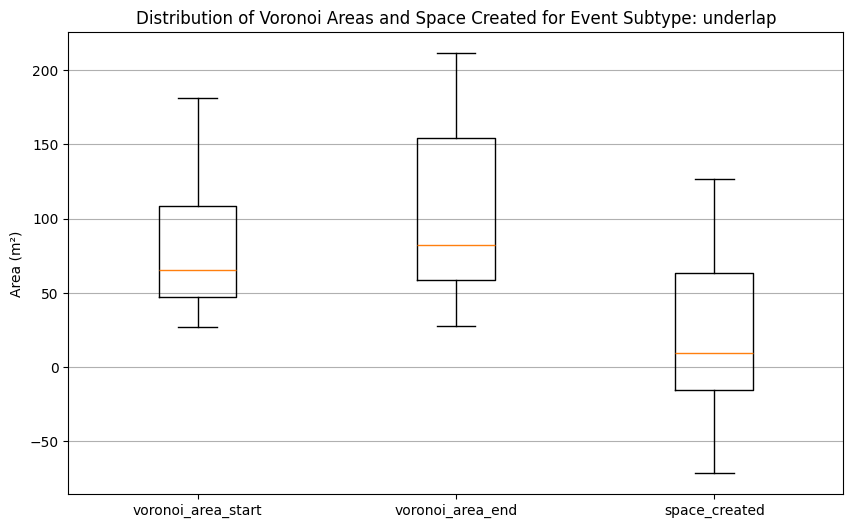

C:\Users\g4a4b\AppData\Local\Temp\ipykernel_21820\3839755185.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subtype_df[c].dropna() for c in cols], labels=cols)


Number of events for subtype dropping_off: 26
Percentage of total events: 3.66%


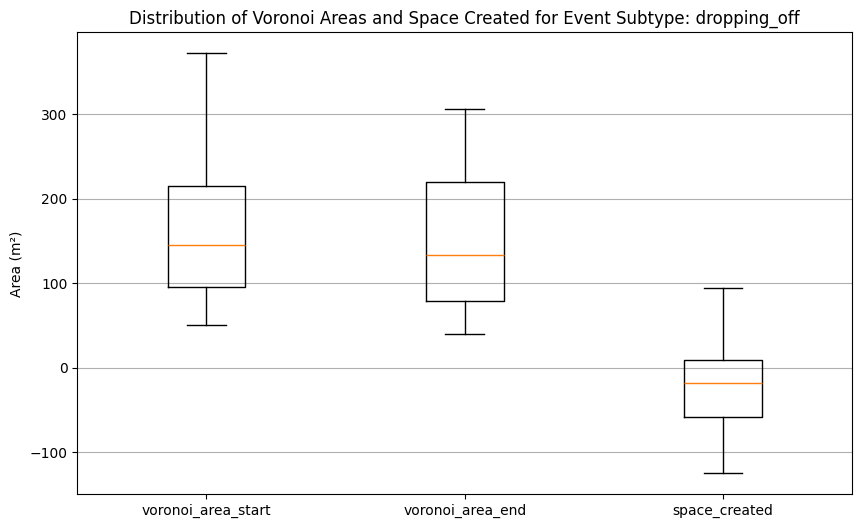

Number of events for subtype pulling_wide: 38
Percentage of total events: 5.35%


C:\Users\g4a4b\AppData\Local\Temp\ipykernel_21820\3839755185.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subtype_df[c].dropna() for c in cols], labels=cols)


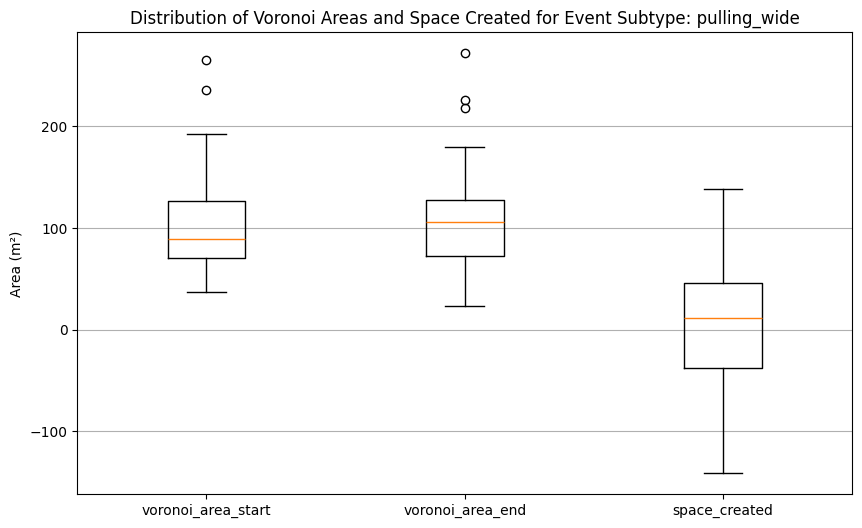

Number of events for subtype behind: 25
Percentage of total events: 3.52%


C:\Users\g4a4b\AppData\Local\Temp\ipykernel_21820\3839755185.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subtype_df[c].dropna() for c in cols], labels=cols)


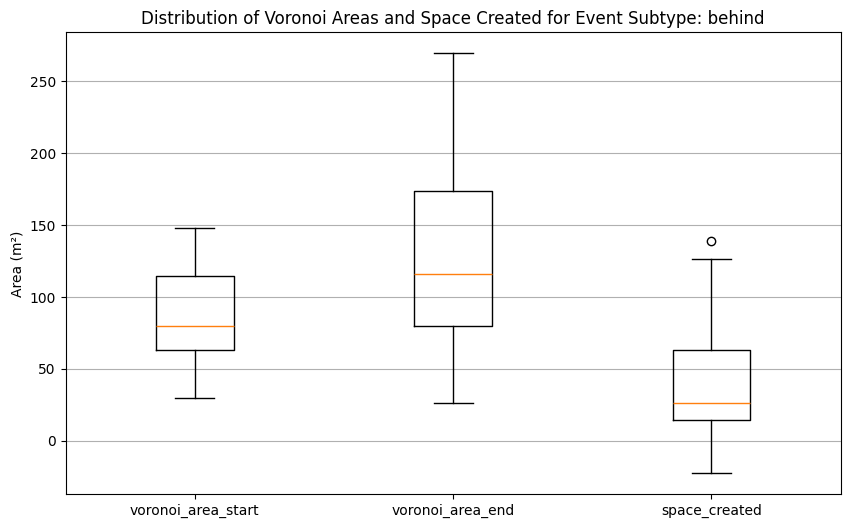

Number of events for subtype overlap: 7
Percentage of total events: 0.99%


C:\Users\g4a4b\AppData\Local\Temp\ipykernel_21820\3839755185.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subtype_df[c].dropna() for c in cols], labels=cols)


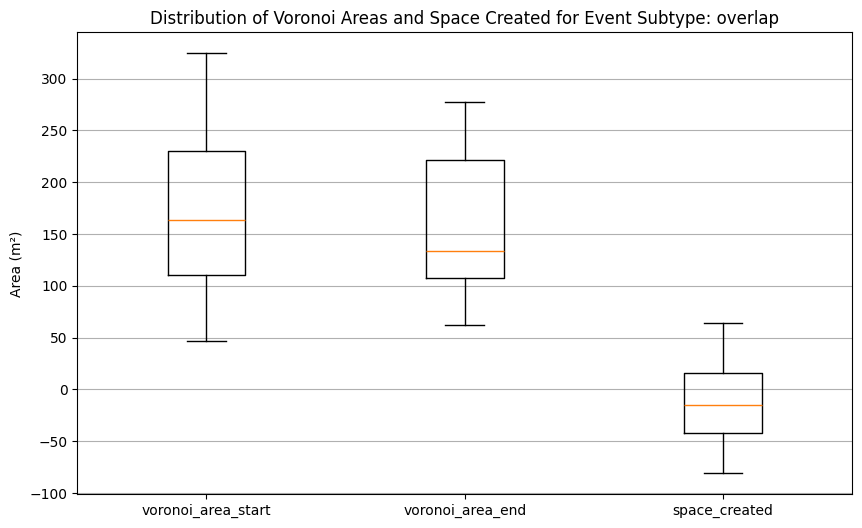

C:\Users\g4a4b\AppData\Local\Temp\ipykernel_21820\3839755185.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df[c].dropna() for c in cols], labels=cols)


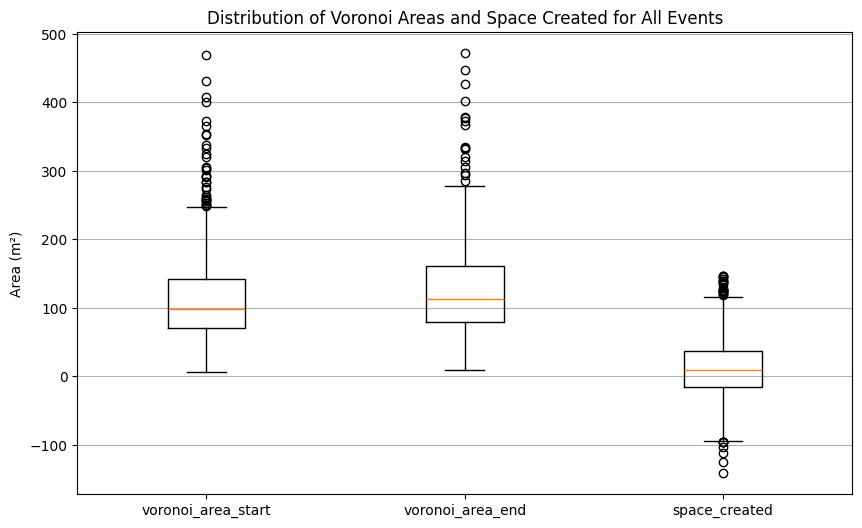

In [67]:
cols = ["voronoi_area_start", "voronoi_area_end", "space_created"]
df = mid_obe[cols]

# create dataframe for each event subtype
event_subtype_dfs = {subtype: mid_obe[mid_obe['event_subtype'] == subtype][cols] for subtype in mid_obe['event_subtype'].unique()}

# draw boxplot for voronoi areas and space created for each event subtype
for subtype, subtype_df in event_subtype_dfs.items():
    print(f"Number of events for subtype {subtype}: {len(subtype_df)}")
    print(f"Percentage of total events: {len(subtype_df) / len(mid_obe) * 100:.2f}%")
    plt.figure(figsize=(10,6))
    plt.boxplot([subtype_df[c].dropna() for c in cols], labels=cols)
    plt.title(f"Distribution of Voronoi Areas and Space Created for Event Subtype: {subtype}")
    plt.ylabel("Area (m²)")
    plt.grid(True, axis='y')
    plt.show()

#boxplot for all events together
plt.figure(figsize=(10,6))
plt.boxplot([df[c].dropna() for c in cols], labels=cols)
plt.title("Distribution of Voronoi Areas and Space Created for All Events")
plt.ylabel("Area (m²)")
plt.grid(True, axis='y')
plt.show()

Number of events for subtype run_ahead_of_the_ball: 238
Percentage of total events: 20.05%


C:\Users\g4a4b\AppData\Local\Temp\ipykernel_21820\3839755185.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subtype_df[c].dropna() for c in cols], labels=cols)


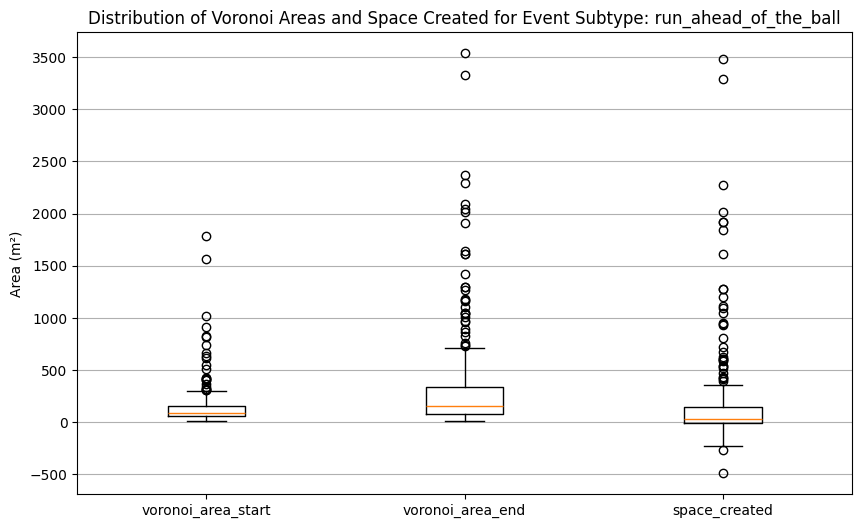

Number of events for subtype coming_short: 416
Percentage of total events: 35.05%


C:\Users\g4a4b\AppData\Local\Temp\ipykernel_21820\3839755185.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subtype_df[c].dropna() for c in cols], labels=cols)


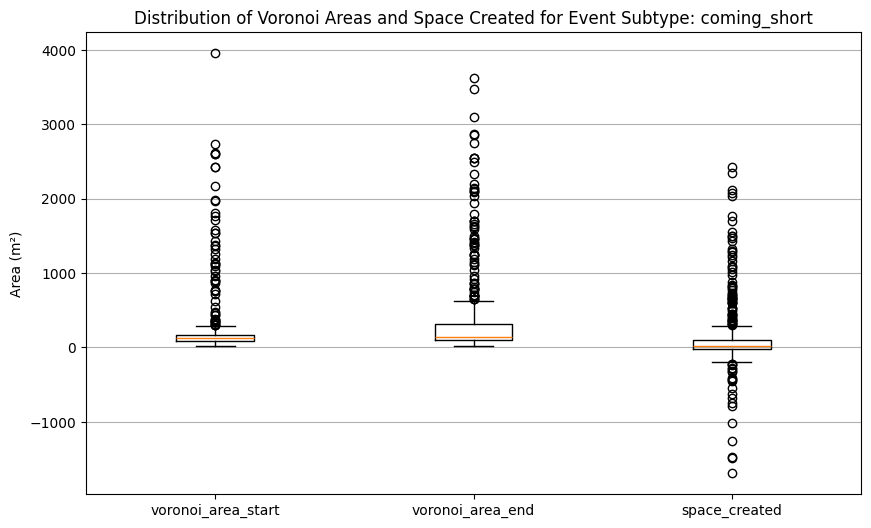

Number of events for subtype support: 250
Percentage of total events: 21.06%


C:\Users\g4a4b\AppData\Local\Temp\ipykernel_21820\3839755185.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subtype_df[c].dropna() for c in cols], labels=cols)


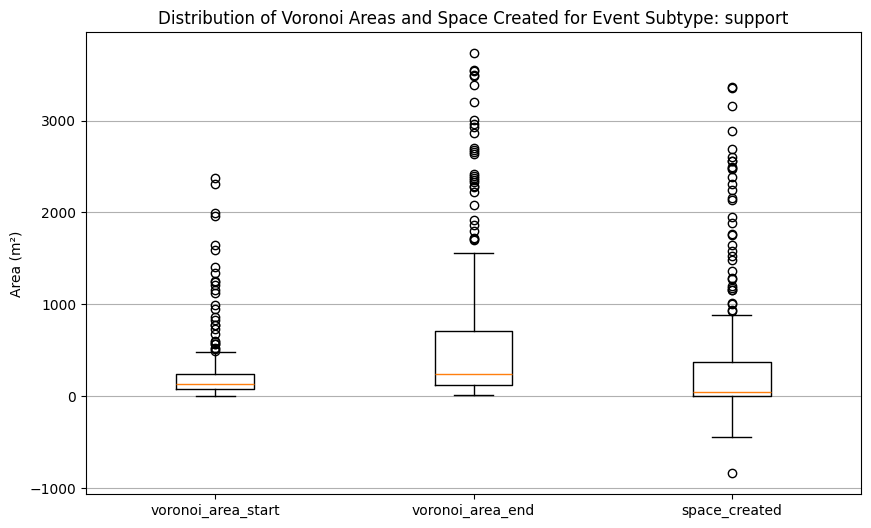

C:\Users\g4a4b\AppData\Local\Temp\ipykernel_21820\3839755185.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subtype_df[c].dropna() for c in cols], labels=cols)


Number of events for subtype pulling_half_space: 40
Percentage of total events: 3.37%


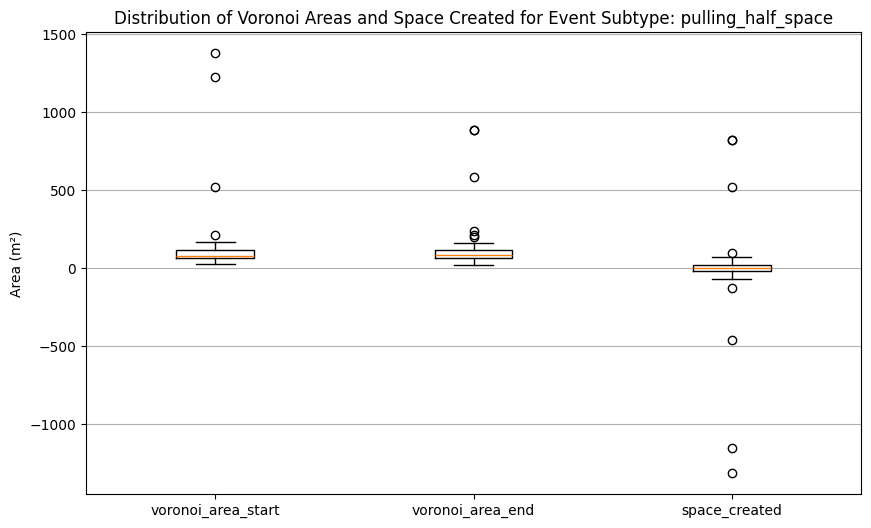

Number of events for subtype cross_receiver: 40
Percentage of total events: 3.37%


C:\Users\g4a4b\AppData\Local\Temp\ipykernel_21820\3839755185.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subtype_df[c].dropna() for c in cols], labels=cols)


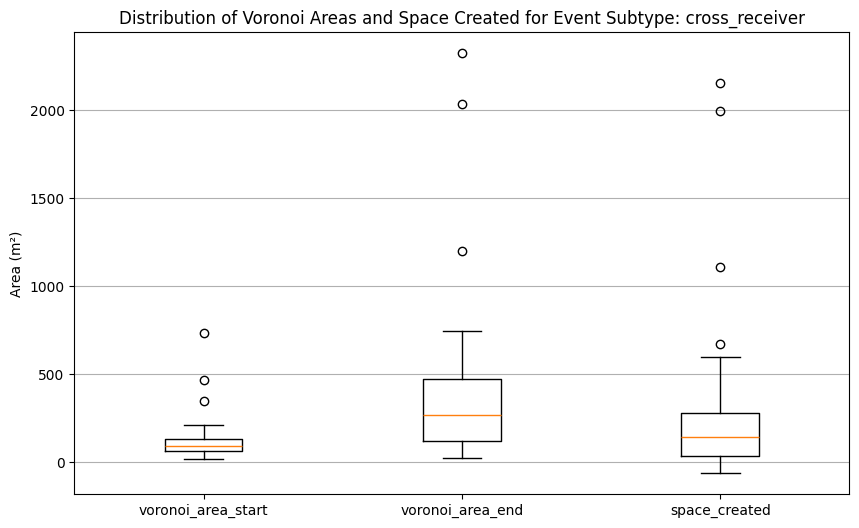

Number of events for subtype underlap: 30
Percentage of total events: 2.53%


C:\Users\g4a4b\AppData\Local\Temp\ipykernel_21820\3839755185.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subtype_df[c].dropna() for c in cols], labels=cols)


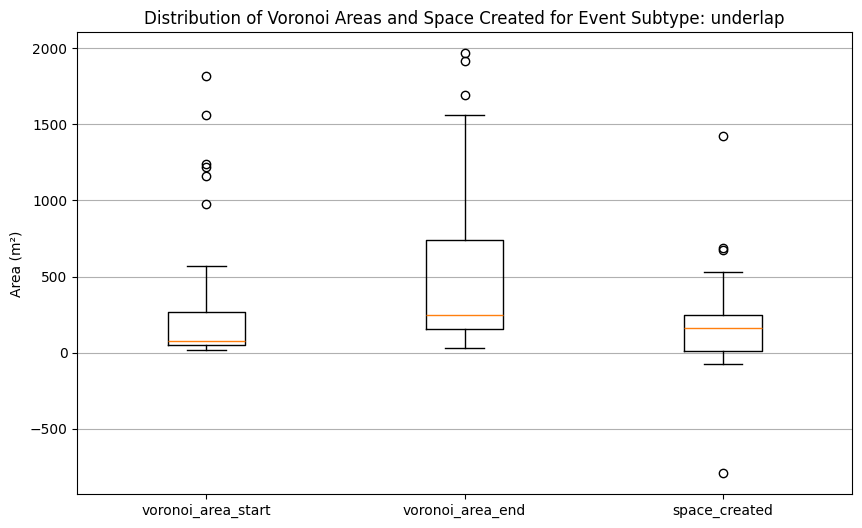

Number of events for subtype dropping_off: 71
Percentage of total events: 5.98%


C:\Users\g4a4b\AppData\Local\Temp\ipykernel_21820\3839755185.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subtype_df[c].dropna() for c in cols], labels=cols)


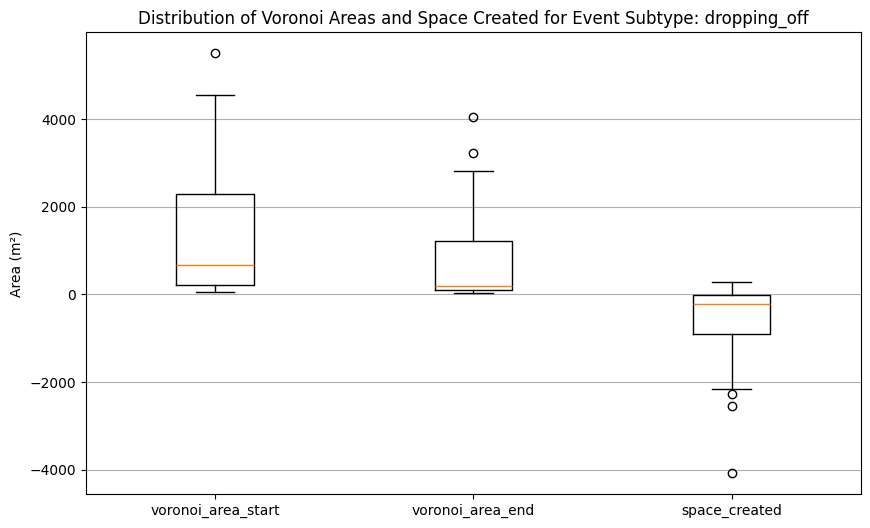

Number of events for subtype pulling_wide: 47
Percentage of total events: 3.96%


C:\Users\g4a4b\AppData\Local\Temp\ipykernel_21820\3839755185.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subtype_df[c].dropna() for c in cols], labels=cols)


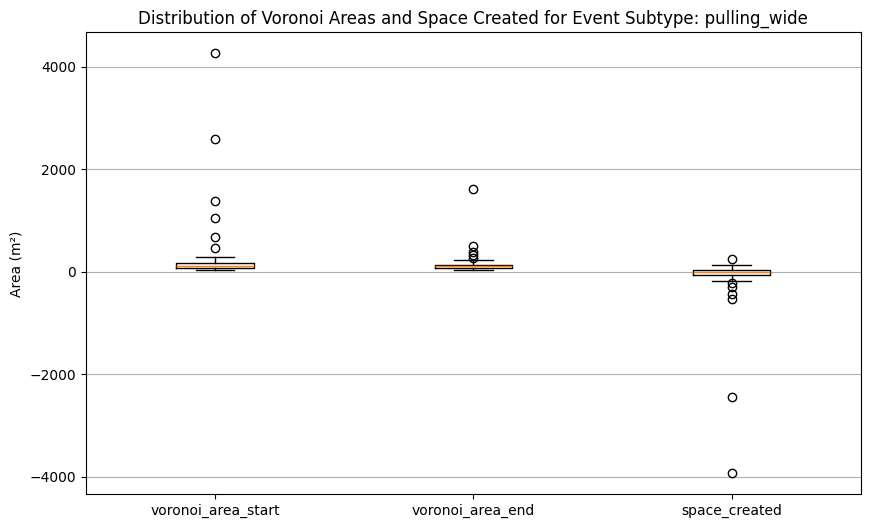

Number of events for subtype behind: 40
Percentage of total events: 3.37%


C:\Users\g4a4b\AppData\Local\Temp\ipykernel_21820\3839755185.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subtype_df[c].dropna() for c in cols], labels=cols)


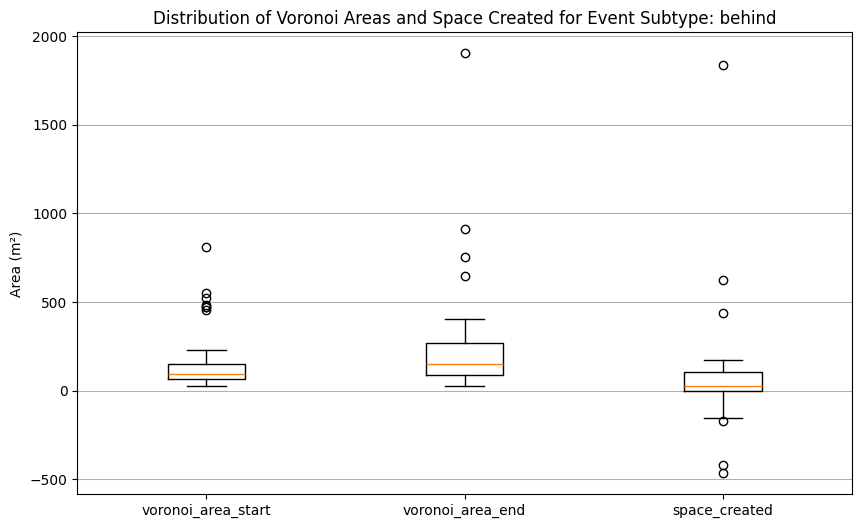

C:\Users\g4a4b\AppData\Local\Temp\ipykernel_21820\3839755185.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subtype_df[c].dropna() for c in cols], labels=cols)


Number of events for subtype overlap: 15
Percentage of total events: 1.26%


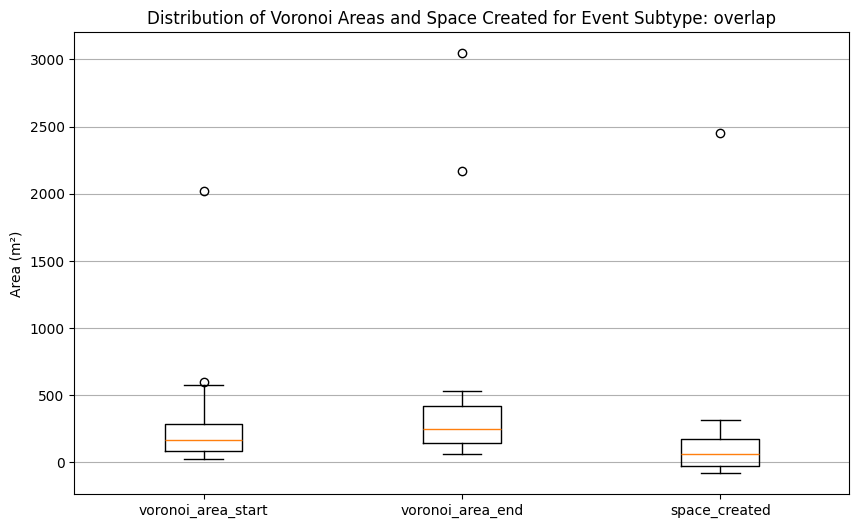

C:\Users\g4a4b\AppData\Local\Temp\ipykernel_21820\3839755185.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df[c].dropna() for c in cols], labels=cols)


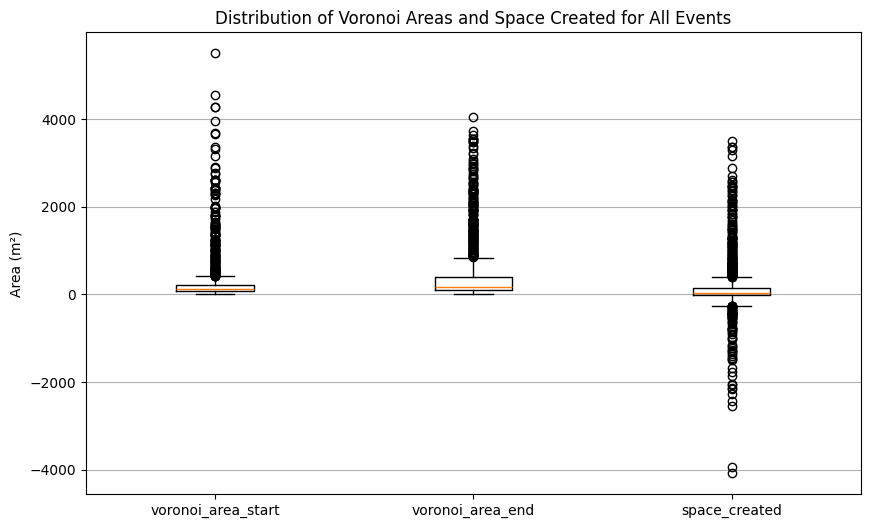

In [58]:
cols = ["voronoi_area_start", "voronoi_area_end", "space_created"]
df = mid_obe[cols]

# create dataframe for each event subtype
event_subtype_dfs = {subtype: mid_obe[mid_obe['event_subtype'] == subtype][cols] for subtype in mid_obe['event_subtype'].unique()}

# draw boxplot for voronoi areas and space created for each event subtype
for subtype, subtype_df in event_subtype_dfs.items():
    print(f"Number of events for subtype {subtype}: {len(subtype_df)}")
    print(f"Percentage of total events: {len(subtype_df) / len(mid_obe) * 100:.2f}%")
    plt.figure(figsize=(10,6))
    plt.boxplot([subtype_df[c].dropna() for c in cols], labels=cols)
    plt.title(f"Distribution of Voronoi Areas and Space Created for Event Subtype: {subtype}")
    plt.ylabel("Area (m²)")
    plt.grid(True, axis='y')
    plt.show()

#boxplot for all events together
plt.figure(figsize=(10,6))
plt.boxplot([df[c].dropna() for c in cols], labels=cols)
plt.title("Distribution of Voronoi Areas and Space Created for All Events")
plt.ylabel("Area (m²)")
plt.grid(True, axis='y')
plt.show()

In [19]:
def calculate_minutes_played(all_metadata):
    minutes_played = {}
    for metadata in all_metadata:
        for player in metadata['players']:
            player_id = player['id']
            if player_id not in minutes_played:
                minutes_played[player_id] = [0,0]
            total = player.get("playing_time", {}).get("total")
            minutes = total.get("minutes_played") if total else 0
            minutes_played[player_id][0] += minutes
            minutes_played[player_id][1] += 1
    df_minutes = (pd.DataFrame.from_dict(minutes_played, orient="index", columns=["minutes_played", "matches"])
    .rename_axis("player_id")
    .reset_index()
    )
    return df_minutes


In [85]:
def space_creation_per_90(mid_obe, all_metadata):
    # Calculate total minutes played per player
    minutes_played = calculate_minutes_played(all_metadata)

    # --- Group by player and event_subtype ---
    df_space_runtype = (
        mid_obe.groupby(["player_id", "event_subtype"], as_index=False)
        .agg(
            total_space_created=("space_created", "sum"),
            num_runs=("space_created", "count")
        )
    )

    df_space_runtype = df_space_runtype.merge(
        minutes_played[["player_id", "minutes_played"]],
        on="player_id",
        how="left"
    )

    df_space_runtype["space_created_per_90_runtype"] = (
        df_space_runtype["total_space_created"] / df_space_runtype["minutes_played"] * 90
    )

    # --- Group by player and third_start ---
    df_space_third = (
        mid_obe.groupby(["player_id", "third_start"], as_index=False)
        .agg(
            total_space_created=("space_created", "sum"),
            num_runs=("space_created", "count")
        )
    )

    df_space_third = df_space_third.merge(
        minutes_played[["player_id", "minutes_played"]],
        on="player_id",
        how="left"
    )

    df_space_third["space_created_per_90_third"] = (
        df_space_third["total_space_created"] / df_space_third["minutes_played"] * 90
    )

    # --- Overall per player ---
    df_total_space = (
        mid_obe.groupby("player_id", as_index=False)
        .agg(total_space_created=("space_created", "sum"))
        .merge(minutes_played[["player_id", "minutes_played"]], on="player_id", how="left")
    )
    df_total_space["space_created_per90_overall"] = (
        df_total_space["total_space_created"] / df_total_space["minutes_played"] * 90
    )

    return df_space_runtype, df_space_third, df_total_space


In [86]:
df_player_runtype, df_space_third, df_total_space = space_creation_per_90(mid_obe, all_metadata)

In [92]:
## ------ PUSH DEFENSIVE LINE ANALYSIS ------ ##

def push_defensive_line_analysis(de_all_matches):

    mid_obe = midfielders_obe(de_all_matches)
    in_behind_runs = mid_obe[mid_obe["event_subtype"] == "behind"]

    # Group by player_id to get total runs and total runs with push_defensive_line equals True
    df_in_behind = (
        in_behind_runs.groupby("player_id", as_index=False)
        .agg(
            total_runs=("event_subtype", "count"),
            push_defensive_line_runs=("push_defensive_line", "sum")
        )
    )

    # get minutes played per player
    minutes_played = calculate_minutes_played(all_metadata)

    # Merge minutes played
    df_in_behind = df_in_behind.merge(
        minutes_played[["player_id", "minutes_played"]],
        on="player_id",
        how="left"
    )

    # Calculate total runs and push defensive line per 90min
    df_in_behind["total_runs_per90"] = (
        df_in_behind["total_runs"] / df_in_behind["minutes_played"] * 90
    )
    df_in_behind["push_defensive_line_per90"] = (
        df_in_behind["push_defensive_line_runs"] / df_in_behind["minutes_played"] * 90
    )

    # Calculate percentage of runs that push defensive line
    df_in_behind["percentage_push_defensive_line"] = (
        df_in_behind["push_defensive_line_runs"] / df_in_behind["total_runs"] * 100
    )

    return df_in_behind

In [93]:
print("Push Defensive Line Analysis:")
df_push_defensive_line = push_defensive_line_analysis(de_all_matches)
print(df_push_defensive_line)

Push Defensive Line Analysis:
    player_id  total_runs push_defensive_line_runs  minutes_played  \
0        7252           7                        1           86.13   
1       12120           1                     True           47.45   
2       14736           1                     True          317.33   
3       23418           2                        1          328.12   
4       26969           1                    False          159.53   
5       27003           1                    False          143.01   
6       50959           1                    False           72.45   
7       51046           1                     True           88.17   
8       51681           2                        1          120.48   
9      104563           5                        2          197.47   
10     133854           2                        1          121.18   
11     157294           1                     True          156.50   
12     159688           1                    False          

In [ ]:
## ------ SEPARATION GAIN ANALYSIS ------ ##

def separation_gain(de_all_matches, all_metadata):

    mid_obe = midfielders_obe(de_all_matches)

    # Calculate total minutes played per player
    minutes_played = calculate_minutes_played(all_metadata)

    # --- Group by player and event_subtype ---
    df_sep_gain_subtype = (
        mid_obe.groupby(["player_id", "event_subtype"], as_index=False)
        .agg(
            sum_sep_gain=("separation_gain", "sum"),
            num_runs=("separation_gain", "count")
        )
    )

    df_sep_gain_subtype = df_sep_gain_subtype.merge(
        minutes_played[["player_id", "minutes_played"]],
        on="player_id",
        how="left"
    )

    df_sep_gain_subtype["sum_sep_gain_per90_subtype"] = (
        df_sep_gain_subtype["sum_sep_gain"] / df_sep_gain_subtype["minutes_played"] * 90
    )

    # --- Group by player and third end ---
    df_sep_gain_third = (
        mid_obe.groupby(["player_id", "third_end"], as_index=False)
        .agg(
            sum_sep_gain=("separation_gain", "sum"),
            num_runs=("separation_gain", "count")
        )
    )

    df_sep_gain_third = df_sep_gain_third.merge(
        minutes_played[["player_id", "minutes_played"]],
        on="player_id",
        how="left"
    )

    df_sep_gain_third["sum_sep_gain_per90_third"] = (
        df_sep_gain_third["sum_sep_gain"] / df_sep_gain_third["minutes_played"] * 90
    )

    # --- Overall per player ---
    df_sep_gain = (
        mid_obe.groupby("player_id", as_index=False)
        .agg(sum_sep_gain=("separation_gain", "sum"))
        .merge(minutes_played[["player_id", "minutes_played"]], on="player_id", how="left")
    )
    df_sep_gain["sum_sep_gain_per90"] = (
        df_sep_gain["sum_sep_gain"] / df_sep_gain["minutes_played"] * 90
    )

    return df_sep_gain_subtype, df_sep_gain_third, df_sep_gain
    
    

In [24]:
df_sep_gain_subtype, df_sep_gain_third, df_sep_gain = separation_gain(de_all_matches, all_metadata)
print("Separation Gain Analysis:")
print(df_sep_gain)

Separation Gain Analysis:
    player_id  sum_sep_gain  minutes_played  sum_sep_gain_per90
0        7252        -24.13           86.13          -25.214211
1       11117         14.20          183.18            6.976744
2       12120        -12.81           47.45          -24.297155
3       14736        -41.83          317.33          -11.863675
4       23418         28.55          328.12            7.830976
5       26969          6.36          159.53            3.588040
6       27003         -3.54          143.01           -2.227816
7       28293          8.67           96.00            8.128125
8       29856         -5.62           98.72           -5.123582
9       50949          2.27           60.65            3.368508
10      50951         21.19          219.39            8.692739
11      50959          0.78           72.45            0.968944
12      50978        -15.60           86.26          -16.276374
13      50992          2.13          197.47            0.970780
14      51002 

In [25]:
## ------ AVG DISTANCE TO DEFENDERS ANALYSIS ------ ##

def avg_distance_2(mid_obe, all_tracking):

    for row in mid_obe.itertuples():
        # Find the match in all_tracking
        match = next((m for m in all_tracking if int(m.metadata.game_id) == int(row.match_id)), None)
        if not match:
                raise ValueError(f"Match {row.match_id} not found in all_tracking")
        
        # Find the start frame in the match frames
        start_frame = next((f for f in match.frames if int(f.frame_id) == int(row.frame_start)), None)
        if not start_frame:
            print(f"Start frame {row.frame_start} not found in match {row.match_id}")
            continue  # Skip if start frame not found
        
        end_frame = next((f for f in match.frames if int(f.frame_id) == int(row.frame_end)), None)
        if not end_frame:
            print(f"End frame {row.frame_end} not found in match {row.match_id}")
            continue  # Skip if end frame not found
        
        # Get player coordinates at start frame
        player_coord = None
        player_team = None
        for player, coord in start_frame.players_coordinates.items():
            if player.player_id == str(row.player_id):
                player_coord = np.array([coord.x, coord.y])
                player_team = player.team.team_id
                break

        if player_coord is None:
            continue

        # --- Start frame distances ---
        opponents_start = np.array([[c.x, c.y] for p, c in start_frame.players_coordinates.items()
                                    if p.team.team_id != player_team])
        if len(opponents_start) > 0:
            distances_start = cdist([player_coord], opponents_start).flatten()
            close_start = distances_start[distances_start <= 5]
            avg_distance_start = close_start.mean() if len(close_start) > 0 else np.nan
        else:
            avg_distance_start = np.nan

        # Get player coordinates at end frame
        player_coord = None
        player_team = None
        for player, coord in end_frame.players_coordinates.items():
            if player.player_id == str(row.player_id):
                player_coord = np.array([coord.x, coord.y])
                player_team = player.team.team_id
                break

        if player_coord is None:
            continue

        # --- End frame distances ---
        opponents_end = np.array([[c.x, c.y] for p, c in end_frame.players_coordinates.items()
                                if p.team.team_id != player_team])
        if len(opponents_end) > 0:
            distances_end = cdist([player_coord], opponents_end).flatten()
            close_end = distances_end[distances_end <= 5]
            avg_distance_end = close_end.mean() if len(close_end) > 0 else np.nan
        else:
            avg_distance_end = np.nan

        # Store results in mid_obe DataFrame
        mid_obe.at[row.Index, 'def_density_change'] = avg_distance_end - avg_distance_start
        
    return mid_obe

In [ ]:
def avg_distance_analysis(mid_obe, all_tracking, all_metadata):

    mid_obe = avg_distance_2(mid_obe, all_tracking)

    # Calculate total minutes played per player
    minutes_played = calculate_minutes_played(all_metadata)

    # --- Group by player and event_subtype ---
    df_def_density_subtype = (
        mid_obe.groupby(["player_id", "event_subtype"], as_index=False)
        .agg(
            total_def_density_change=("def_density_change", "sum"),
            num_runs=("def_density_change", "count")
        )
    )

    df_def_density_subtype = df_def_density_subtype.merge(
        minutes_played[["player_id", "minutes_played"]],
        on="player_id",
        how="left"
    )

    df_def_density_subtype["def_density_change_per90_subtype"] = (
        df_def_density_subtype["total_def_density_change"] / df_def_density_subtype["minutes_played"] * 90
    )

    # --- Group by player and third_end ---
    df_def_density_third = (
        mid_obe.groupby(["player_id", "third_end"], as_index=False)
        .agg(
            total_def_density_change=("def_density_change", "sum"),
            num_runs=("def_density_change", "count")
        )
    )
    df_def_density_third = df_def_density_third.merge(
        minutes_played[["player_id", "minutes_played"]],
        on="player_id",
        how="left"
    )
    df_def_density_third["def_density_change_per90_third"] = (
        df_def_density_third["total_def_density_change"] / df_def_density_third["minutes_played"] * 90
    )

    # --- Overall per player ---
    df_def_density = (
        mid_obe.groupby("player_id", as_index=False)
        .agg(total_def_density_change=("def_density_change", "sum"))
        .merge(minutes_played[["player_id", "minutes_played"]], on="player_id", how="left")
    )
    df_def_density["def_density_change_per90"] = (
        df_def_density["total_def_density_change"] / df_def_density["minutes_played"] * 90
    )

    return df_def_density_subtype, df_def_density_third, df_def_density

In [27]:
df_def_density_subtype, df_def_density_third, df_def_density = avg_distance_analysis(mid_obe, all_tracking, all_metadata)
print("Average Distance to Defenders Analysis:")
print(df_def_density)

Start frame 2523 not found in match 2017461
Start frame 2529 not found in match 2017461
End frame 54489 not found in match 2015213
End frame 30255 not found in match 2013725
End frame 55652 not found in match 2013725
End frame 18801 not found in match 2011166
End frame 44696 not found in match 2011166
End frame 44694 not found in match 2011166
End frame 930 not found in match 2006229
End frame 32272 not found in match 2006229
End frame 34131 not found in match 2006229
Start frame 52029 not found in match 2006229
End frame 35966 not found in match 1996435
End frame 43171 not found in match 1996435
End frame 53595 not found in match 1996435
End frame 5481 not found in match 1953632
End frame 8632 not found in match 1953632
End frame 15468 not found in match 1953632
End frame 30795 not found in match 1953632
End frame 40608 not found in match 1953632
End frame 11177 not found in match 1925299
End frame 30128 not found in match 1925299
End frame 30136 not found in match 1925299
End frame 8

In [ ]:
## ------ LEAD TO SHOT ANALYSIS ------ ##

def lead_to_shot_analysis(mid_obe):

    # Group by player_id to get total runs and total runs leading to shot
    df_lead_to_shot = (
        mid_obe.groupby("player_id", as_index=False)
        .agg(
            total_runs=("lead_to_shot", "count"),
            lead_to_shot_runs=("lead_to_shot", "sum")
        )
    )

    # Calculate percentage of runs that lead to shot
    df_lead_to_shot["percentage_lead_to_shot"] = (
        df_lead_to_shot["lead_to_shot_runs"] / df_lead_to_shot["total_runs"] * 100
    )

    return df_lead_to_shot
    


In [ ]:
## ------ LEAD TO A CHANGE OF PHASE ------ ##